<a href="https://colab.research.google.com/github/alpserin/object-detection-pytorch/blob/main/object-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import os
import random

In [ ]:
# Data from Alp's Drive
from google.colab import drive
import os 
drive.mount('/content/gdrive/')

In [ ]:
#data from Boris' Gdrive
from google.colab import drive
import os
drive.mount('/content/gdrive')
#!unzip gdrive/MyDrive/data/Dotcreate/DatasetNew.zip -d /content/data_dir/

Mounted at /content/gdrive


In [ ]:
IMAGE_SIZE = 64
DATA_DIR = '/content/gdrive/MyDrive/data/Dotcreate/Dataset5000'
#DATA_DIR = '/content/gdrive/MyDrive/Dataset5000'
labels = ["10","100","150","20","200","30","40","5","50","75"]


In [ ]:
#Normalization values for the whole dataset (Don't run unless needed)

#Load the whole dataset
norm_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
    ])

norm_imgload = datasets.ImageFolder(DATA_DIR, transform = norm_transform)
norm_dataload = torch.utils.data.DataLoader(dataset=norm_imgload, 
                                            batch_size=len(norm_imgload),
                                            shuffle = False, 
                                            num_workers = 0
                                            )


#Normal values find function
def normvals(dataloader):
  images, lbl = next(iter(dataloader))
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std

mean, std = normvals(norm_dataload)
print(mean, std)
#OUTPUT for dotcreate5000= tensor([0.7925, 0.7549, 0.7549]) tensor([0.3892, 0.3943, 0.3943])

In [ ]:
mean, std = [0.7925, 0.7549, 0.7549], [0.3892, 0.3943, 0.3943]

In [ ]:

#Transforms
train_transform = transforms.Compose([
                                  transforms.RandomRotation(degrees = 30),
                                  transforms.RandomHorizontalFlip( p= 0.2 ),
                                  transforms.RandomVerticalFlip( p= 0.2 ),
                                  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                  #transforms.RandomResizedCrop(size = IMAGE_SIZE),
                                  #transforms.Grayscale(),
                                  transforms.ColorJitter(brightness = 0.2,
                                                         contrast = 0.2,
                                                         saturation = 0.2,
                                                         hue = 0.2 
                                                         ),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)
                                  ])

val_transform = transforms.Compose([
                                  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)
                                  ])

#Loading the custom dataset
dataset_train = datasets.ImageFolder(DATA_DIR, transform = train_transform)
dataset_val = datasets.ImageFolder(DATA_DIR, transform = val_transform)


#Splitting the data into trainning and validation subsets
indices = torch.randperm(len(dataset_train))
val_size = int(len(dataset_train)*0.2)
dataset_train = torch.utils.data.Subset(dataset_train, indices[:-val_size])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-val_size:])


#plt.imshow(list(dataset[0]).permute(1, 2, 0))
for batch in dataset_train:
   print(batch)
   break

(tensor([[[-2.0362, -2.0362, -2.0362,  ..., -2.0362, -2.0362, -2.0362],
         [-2.0362, -2.0362, -2.0362,  ..., -2.0362, -2.0362, -2.0362],
         [-2.0362, -2.0362, -2.0362,  ..., -2.0362, -2.0362, -2.0362],
         ...,
         [-2.0362, -2.0362, -2.0362,  ..., -2.0362, -2.0362, -2.0362],
         [-2.0362, -2.0362, -2.0362,  ..., -2.0362, -2.0362, -2.0362],
         [-2.0362, -2.0362, -2.0362,  ..., -2.0362, -2.0362, -2.0362]],

        [[-1.9145, -1.9145, -1.9145,  ..., -1.9145, -1.9145, -1.9145],
         [-1.9145, -1.9145, -1.9145,  ..., -1.9145, -1.9145, -1.9145],
         [-1.9145, -1.9145, -1.9145,  ..., -1.9145, -1.9145, -1.9145],
         ...,
         [-1.9145, -1.9145, -1.9145,  ..., -1.9145, -1.9145, -1.9145],
         [-1.9145, -1.9145, -1.9145,  ..., -1.9145, -1.9145, -1.9145],
         [-1.9145, -1.9145, -1.9145,  ..., -1.9145, -1.9145, -1.9145]],

        [[-1.9145, -1.9145, -1.9145,  ..., -1.9145, -1.9145, -1.9145],
         [-1.9145, -1.9145, -1.9145,  ..., -

In [ ]:
#Every PyTorch model must inherit from torch.nn.Module
#nn.Module has very useful functions for models
class CNN(nn.Module):
    
    # Constructor: (out_1: Output channels of first CNN Layer), (out_2: Output channels of second CNN Layer), (number_of_classes: Number of classes to detect)
    def __init__(self, out_1=32, out_2=64, number_of_classes=10):
        super().__init__()
        #Create first Convolution Layer with input of 1 channel (grayscale) and output of out_1 channels
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=5, padding=2)

        #Initialize the weights of the first Convolution Layer with He initialization for Leaky ReLU activation
        nn.init.kaiming_uniform_(self.cnn1.weight, nonlinearity='relu')

        #Create Batch Normalization for first Convolution Layer
        self.conv1_bn = nn.BatchNorm2d(out_1)

        #Create Leaky ReLU activation
        self.leaky_relu = nn.LeakyReLU()

        #Create Max Pooling for first Convolution Layer
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        #Create second Convolution Layer with input of out_1 channels (from first layer) and output of out_2 channels
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, padding=2)

        #Initialize the weights of the second Convolution Layer with He initialization for Leaky ReLU activation
        nn.init.kaiming_uniform_(self.cnn2.weight, nonlinearity='leaky_relu')

        #Create Batch Normalization for second Convolution Layer
        self.conv2_bn = nn.BatchNorm2d(out_2)

        #Create Max Pooling for second Convolution Layer
        self.maxpool2=nn.MaxPool2d(kernel_size=2)

        #Create a fully connected layer for the CNN. The input shape is the flattened convolution output. If output is (3, 28, 28), input is 28 * 28 * 3.
        self.fc1 = nn.Linear(out_2 * int(IMAGE_SIZE/4) * int(IMAGE_SIZE/4), number_of_classes)

        # Add Dropout
        self.dropout = nn.Dropout(0.25)
    
    # Prediction (x is input)
    # The forward function is automatically called when we create an instance of the class and call it.
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = self.leaky_relu(x)
        x = self.maxpool1(x)
        
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = self.leaky_relu(x)
        x = self.maxpool2(x)

        x = self.dropout(x)
        
        #Flattening cnn2's output and passing it into a fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [ ]:
#Data Loader for training data
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=20 )

#Data Loader for validation data
test_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=20 )

In [ ]:
import torchsummary as summary
model = CNN()

summary.summary(model, (3, IMAGE_SIZE, IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           2,432
       BatchNorm2d-2           [-1, 32, 64, 64]              64
         LeakyReLU-3           [-1, 32, 64, 64]               0
         MaxPool2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          51,264
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         LeakyReLU-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
           Dropout-9           [-1, 64, 16, 16]               0
           Linear-10                   [-1, 10]         163,850
Total params: 217,738
Trainable params: 217,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 5.00
Params size (MB): 0.83
Estimated T

In [ ]:
#Creating an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025, weight_decay = 1e-4 )

#Use Cross Entropy Loss since this is a classification problem
criterion = nn.CrossEntropyLoss()

# Load model from pth file
# model.load_state_dict(torch.load('/content/gdrive/MyDrive/dotcreate_latest.pth'))

In [ ]:
# To show a progress bar while training
from tqdm import tqdm

training_acc_list=[]
val_acc_list=[]
N_test=len(dataset_val)
N_train = len(dataset_train)
n_epochs=40

for epoch in range(n_epochs):
    #Count how many predictions were correct
    correct = 0

    print()
    print(f"Epoch no. {epoch}")
    #Put model into training mode (uses Dropout if there are Dropout layers)
    model.train()
    #Loop over each sample in the dataloaders.
    for x, y in tqdm(train_loader):
        #Zero the optimizer gradients (PyTorch requires this.)
        optimizer.zero_grad()
        #Make a prediction
        y_hat = model(x)
        #Calculate the loss with the criterion
        loss = criterion(y_hat, y)
        #Initiate backpropagation/calculate derivatives of parameters with respect to the loss.
        loss.backward()
        #Update parameters
        optimizer.step()

        
        
        #Update correct counter
        #Grab the index of the AI's highest probability guess (Each output of model(x) is a tensor of probabilities) 
        correct += (torch.argmax(y_hat, 1) == y).sum().item()
        
    #Calculate accuracy
    accuracy = correct / N_train
    print("Training accuracy: " + str(accuracy))
    training_acc_list.append(accuracy)

    correct=0
    
    #Put model into validation mode (turns off Dropout if there are Dropout layers)
    model.eval()
    for x_test, y_test in test_loader:
        #Make a prediction
        z = model(x_test)
        #Grab the index of the AI's highest probability guess (Each output of model(x) is a tensor of probabilities) 
        y_hat = torch.argmax(z, 1)
        #Update correct counter if the prediction was correct
        correct += (y_hat == y_test).sum().item()
    accuracy = correct / N_test
    print("Validation accuracy: " + str(accuracy))
    val_acc_list.append(accuracy)


Epoch no. 0


100%|██████████| 200/200 [02:01<00:00,  1.64it/s]


Training accuracy: 0.33425
Validation accuracy: 0.5445445445445446

Epoch no. 1


100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


Training accuracy: 0.42525
Validation accuracy: 0.5545545545545546

Epoch no. 2


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Training accuracy: 0.4945
Validation accuracy: 0.5075075075075075

Epoch no. 3


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Training accuracy: 0.546
Validation accuracy: 0.5225225225225225

Epoch no. 4


100%|██████████| 200/200 [02:04<00:00,  1.60it/s]


Training accuracy: 0.577
Validation accuracy: 0.4944944944944945

Epoch no. 5


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Training accuracy: 0.615
Validation accuracy: 0.24224224224224225

Epoch no. 6


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Training accuracy: 0.63775
Validation accuracy: 0.7707707707707707

Epoch no. 7


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Training accuracy: 0.6385
Validation accuracy: 0.8278278278278278

Epoch no. 8


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Training accuracy: 0.6845
Validation accuracy: 0.7287287287287287

Epoch no. 9


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Training accuracy: 0.69775
Validation accuracy: 0.5845845845845846

Epoch no. 10


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Training accuracy: 0.70075
Validation accuracy: 0.6796796796796797

Epoch no. 11


100%|██████████| 200/200 [02:04<00:00,  1.60it/s]


Training accuracy: 0.732
Validation accuracy: 0.6496496496496497

Epoch no. 12


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Training accuracy: 0.7475
Validation accuracy: 0.6966966966966966

Epoch no. 13


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Training accuracy: 0.758
Validation accuracy: 0.8288288288288288

Epoch no. 14


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Training accuracy: 0.76575
Validation accuracy: 0.7147147147147147

Epoch no. 15


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Training accuracy: 0.78075
Validation accuracy: 0.4824824824824825

Epoch no. 16


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Training accuracy: 0.79525
Validation accuracy: 0.7967967967967968

Epoch no. 17


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Training accuracy: 0.79025
Validation accuracy: 0.8758758758758759

Epoch no. 18


100%|██████████| 200/200 [02:04<00:00,  1.61it/s]


Training accuracy: 0.8125
Validation accuracy: 0.8108108108108109

Epoch no. 19


100%|██████████| 200/200 [02:04<00:00,  1.61it/s]


Training accuracy: 0.81325
Validation accuracy: 0.7867867867867868

Epoch no. 20


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Training accuracy: 0.80675
Validation accuracy: 0.7677677677677678

Epoch no. 21


100%|██████████| 200/200 [02:01<00:00,  1.64it/s]


Training accuracy: 0.8125
Validation accuracy: 0.8818818818818819

Epoch no. 22


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Training accuracy: 0.812
Validation accuracy: 0.8458458458458459

Epoch no. 23


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Training accuracy: 0.82975
Validation accuracy: 0.8928928928928929

Epoch no. 24


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Training accuracy: 0.852
Validation accuracy: 0.8958958958958959

Epoch no. 25


100%|██████████| 200/200 [02:00<00:00,  1.67it/s]


Training accuracy: 0.84475
Validation accuracy: 0.8548548548548549

Epoch no. 26


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Training accuracy: 0.84875
Validation accuracy: 0.8728728728728729

Epoch no. 27


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Training accuracy: 0.83825
Validation accuracy: 0.8408408408408409

Epoch no. 28


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Training accuracy: 0.8515
Validation accuracy: 0.8678678678678678

Epoch no. 29


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Training accuracy: 0.8485
Validation accuracy: 0.8188188188188188

Epoch no. 30


100%|██████████| 200/200 [01:59<00:00,  1.68it/s]


Training accuracy: 0.85925
Validation accuracy: 0.8818818818818819

Epoch no. 31


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Training accuracy: 0.8695
Validation accuracy: 0.9309309309309309

Epoch no. 32


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Training accuracy: 0.87275
Validation accuracy: 0.7687687687687688

Epoch no. 33


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Training accuracy: 0.8775
Validation accuracy: 0.943943943943944

Epoch no. 34


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Training accuracy: 0.8875
Validation accuracy: 0.9039039039039038

Epoch no. 35


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Training accuracy: 0.87425
Validation accuracy: 0.7767767767767768

Epoch no. 36


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Training accuracy: 0.883
Validation accuracy: 0.913913913913914

Epoch no. 37


100%|██████████| 200/200 [01:59<00:00,  1.68it/s]


Training accuracy: 0.87825
Validation accuracy: 0.7037037037037037

Epoch no. 38


100%|██████████| 200/200 [02:00<00:00,  1.65it/s]


Training accuracy: 0.876
Validation accuracy: 0.8688688688688688

Epoch no. 39


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Training accuracy: 0.87075
Validation accuracy: 0.8468468468468469


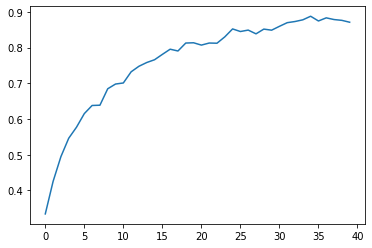

In [ ]:
plt.plot(training_acc_list)

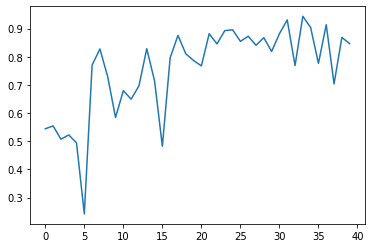

In [ ]:
plt.plot(val_acc_list)

In [ ]:
#We can save our model's weights by running the following:
#torch.save(model.state_dict(), "dotcreate.pth")
#We can save our model's weights by running the following:
# torch.save(model.state_dict(), "/content/gdrive/MyDrive/dotcreate_latest.pth")
#torch.save(model.state_dict(), "/content/gdrive/MyDrive/data/Dotcreate/dotcreate_latest.pth")
#We can load the model's weights by running the following:
model.load_state_dict(torch.load("/content/gdrive/MyDrive/data/Dotcreate/dotcreate_latest.pth"))

<All keys matched successfully>

AI's Prediction: 30
Confidence :  93.4062 % for 30
Confidence :  6.5763 % for 40
Confidence :  0.0159 % for 20


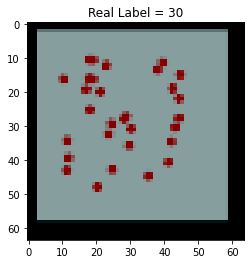

In [ ]:
#Random val image to test the trained model

import numpy as np
model.eval()
randomIndex = random.randint(0, len(dataset_val) -1)
#print(randomIndex)
test = dataset_val[randomIndex]
#print("test:", test)


def show_data(data_sample, size):
  temp = data_sample[0].permute(1, 2, 0)
  plt.imshow(temp.numpy())
  plt.title(f"Real Label = {labels[data_sample[1]]}")

show_data(test, IMAGE_SIZE)
# Turn image of (C, H, W) into (B, C, H, W) to pass into the model
# Take the index of the highest probability from the output tensor and grab the corresponding classification
print("AI's Prediction: " + labels[torch.argmax(model(test[0].view(-1, 3, IMAGE_SIZE, IMAGE_SIZE)), 1)])

# Rescaling the output tensor so that all the values lie in range [0,1] and sum to 1.
class_prob = torch.softmax(model(test[0].view(-1, 3, IMAGE_SIZE, IMAGE_SIZE)), 1)

# Getting the highest probability from the rescaled output tensor
confidence, topclassindex = torch.max(class_prob, dim=1)

k = 3 # Number of confidence ratings we want

# Getting 'k' largest elements and their indexes from our output tensor
values, indexes = torch.topk(class_prob, k)

# Converting these tensors to numpy arrays to use them as indexes
n_values = values.detach().numpy()
n_indexes = indexes.detach().numpy()

# Printing confidence ratings
for i in range(k):
  print("Confidence : ", round(n_values[0][i]*100, 4), '%', "for", labels[int(n_indexes[0][i])])

AI's prediction :  100
Confidence :  37.0565 % for 100
Confidence :  30.4407 % for 5
Confidence :  27.1457 % for 10


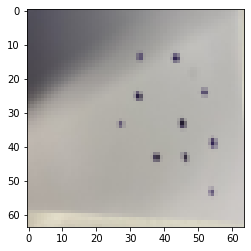

In [ ]:
# Testing a single image with the model
from PIL import Image
import torchvision.transforms.functional as TF

# Loading the image and converting it to RGB
image = Image.open("/content/gdrive/MyDrive/data/Dotcreate/IMG/IMG_3608.jpg")
image = image.convert('RGB')

# Applying transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
    # transforms.Normalize(mean, std)
])

# Adding an additional dimension to our tensor
image = transform(image).unsqueeze(0)

# Initiating and loading the model
model = CNN()
#model.load_state_dict(torch.load("pass"))
# Put model into validation mode (turns off Dropout if there are Dropout layers)
model.eval()

# Passing our image to the model
with torch.no_grad():
  output = model(image)

# Prediction
prediction = output.argmax().item()
print("AI's prediction : ", labels[prediction])
# print("output : ", output)

def show_data_new(data_sample, size):
  temp = data_sample[0].permute(1, 2, 0)
  plt.imshow(temp.numpy())
show_data_new(image, IMAGE_SIZE)


# !!!!!!!!!!!!!!!!!!!!!!!!!!! We have to print our confidence ratings !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!11

# Rescaling our output tensor with softmax
# output_prob = torch.softmax(model(output.view(-1, 3, IMAGE_SIZE, IMAGE_SIZE)), 1)

# # Getting the highest probability from the output tensor
# confidence, topclassindex = torch.max(output_prob, dim=1)

k = 3 # Number of confidence ratings we want

# Getting 'k' largest elements and their indexes from our output tensor
values, indexes = torch.topk(output, k)

# Converting these tensors to numpy arrays to use them as indexes
n_values = values.detach().numpy()
n_indexes = indexes.detach().numpy()

# Printing confidence ratings
for i in range(k):
  print("Confidence : ", round(n_values[0][i]*100, 4), '%', "for", labels[int(n_indexes[0][i])])